In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import pandas as pd
# import data
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [4]:
# compute total bicycle traffic
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [5]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [6]:
# indicator about holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

<ipython-input-7-d22890bac77a>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

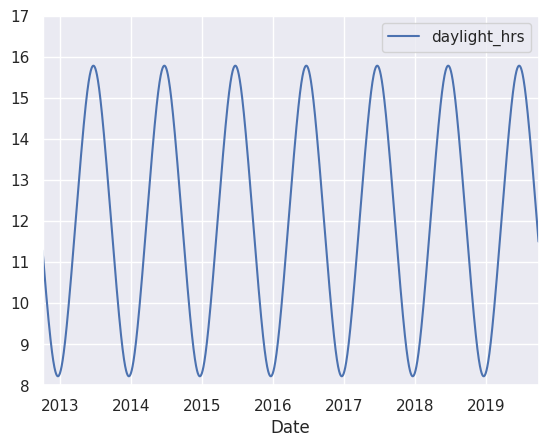

In [7]:
# daylight_hrs indicator
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [8]:
# temperatures are in 1/10 deg C, convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm, convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


In [9]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [10]:
# drops rows will null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

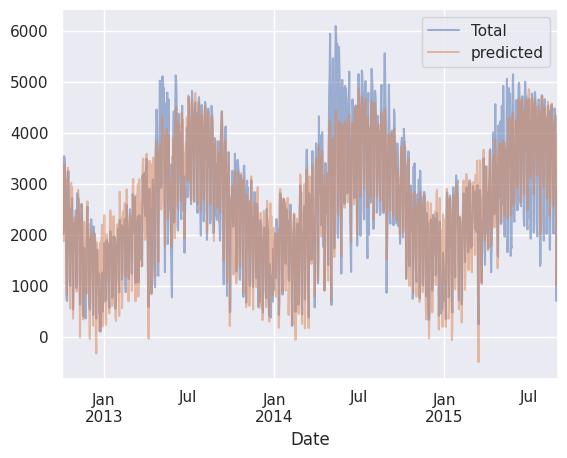

In [11]:
# plot from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

In [12]:
# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [13]:
import matplotlib.pyplot as plt

daily[:5]
daily.corr(method='spearman')

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619643,-0.465832,0.620759,0.429007,0.235085,0.932395
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000398,-0.025984,0.019147,0.017129,0.002658,0.143697
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,0.006232,0.004420,-0.010122,0.003987,0.212646
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000582,0.005944,-0.011469,0.000779,-0.003987,0.197020
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000411,0.010861,-0.001675,-0.015572,-0.002658,0.140759
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000245,0.026654,0.000109,-0.037373,-0.001329,0.033788
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000039,-0.017684,-0.005938,0.028030,0.000000,-0.356990
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000227,-0.006022,-0.004595,0.017129,0.001329,-0.370920
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,-0.050033,-0.068670,0.059115,-0.027033,-0.130353
daylight_hrs,0.619643,0.000398,0.000651,-0.000582,-0.000411,-0.000245,-0.000039,0.000227,-0.078683,1.000000,-0.309827,0.790928,0.307485,0.251385,0.686755


Linear Regression highest accuracy: 
0.8453827595922788


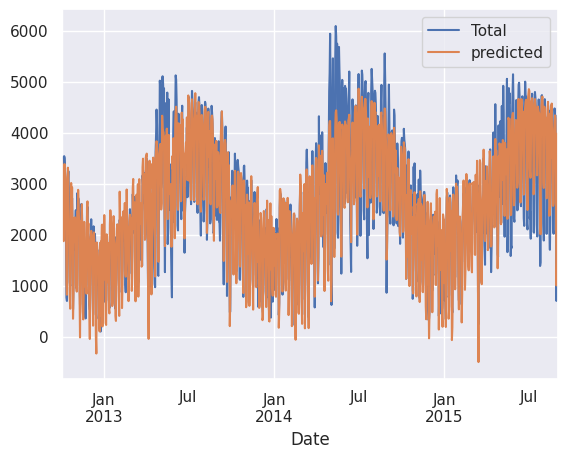

In [39]:
# linear Regression model
from sklearn.model_selection import cross_validate

lrModel = LinearRegression()
lrResults = cross_validate(lrModel, X, y, cv=10)

# fit data to model and plot on graph
lrModel.fit(X,y)
daily['predicted'] = lrModel.predict(X)
daily[['Total', 'predicted']].plot(alpha=1);
# get highest accuracy
highestAcc = max(lrResults['test_score'])
print('Linear Regression highest accuracy: ')
print(highestAcc)


Lasso Regression highest accuracy: 0.8187229693440123


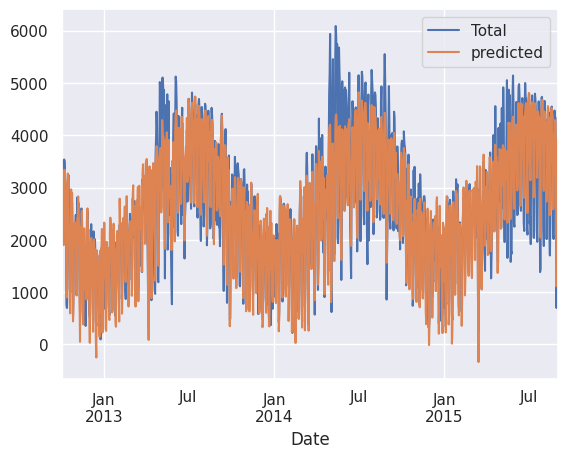

In [20]:
# lasso regression model
from sklearn.linear_model import Lasso

lassoModel = Lasso()
pGrid = {'alpha': np.arange(0,10,0.1)}
lassoGrid = RandomizedSearchCV(estimator=lassoModel, param_distributions=pGrid, n_iter=10)
lassoGrid.fit(X,y)

daily['predicted'] = lassoGrid.predict(X)
daily[['Total', 'predicted']].plot();

# fit data to model and plot on graph
print('Lasso Regression highest accuracy: ' + str(lassoGrid.best_score_))

5
Ridge Regression highest accuracy: 0.8173936931905066


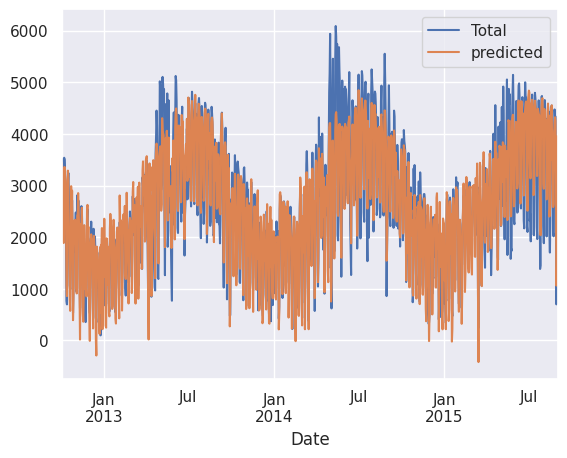

In [38]:
# ridge regression model
from sklearn.linear_model import Ridge

ridgeModel = Ridge()
pGrid = {'alpha': np.arange(0,10,0.1)}
ridgeGrid = RandomizedSearchCV(estimator=ridgeModel, param_distributions=pGrid, n_iter=10)
ridgeGrid.fit(X,y)

daily['predicted'] = ridgeGrid.predict(X)
daily[['Total', 'predicted']].plot();

# plot the graph
print('Ridge Regression highest accuracy: ' + str(ridgeGrid.best_score_))

In [42]:
# which model performs the best
bestModel = []
bestModel.append(lassoGrid.best_score_)
bestModel.append(ridgeGrid.best_score_)
bestModel.append(highestAcc)

print(max(bestModel))
# the best model

0.8453827595922788
